In [2]:
import csv
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, linregress


file1 = "Ravalli_2021_datasets_and_codebook_2.tsv"

as_cols = ["AsWeightedAvg20062011", "AsWeightedAvg20082010"]
u_cols  = ["UWeightedAvg20002011", "UWeightedAvg20082011"]

elevated_records = []
elevated_names = set()

with open(file1, "r", encoding="latin-1") as f:
    reader = csv.DictReader(f, delimiter="\t")

    print("\n~COUNTIES WITH ELEVATED As/U~\n")
    for row in reader:
        try:
            as_vals = [float(row[c]) if row[c] != "999999" else None for c in as_cols]
            u_vals  = [float(row[c]) if row[c] != "999999" else None for c in u_cols]
        except:
            continue

        as_flag = any(v is not None and v >= 10 for v in as_vals)
        u_flag  = any(v is not None and v >= 30 for v in u_vals)

        if as_flag or u_flag:
            elevated_records.append(row)
            elevated_names.add(row["Full.Name"])
            print(row["Full.Name"])



~COUNTIES WITH ELEVATED As/U~

CA,MONO
ID,PAYETTE
KS,DECATUR
KS,KEARNY
KS,RAWLINS
KS,RUSH
KS,SCOTT
MT,JEFFERSON
NE,BOXBUTTE
NE,CUMING
NE,DEUEL
NE,DUNDY
NE,FURNAS
NE,HALL
NE,KEARNEY
NE,MORRILL
NE,POLK
NE,REDWILLOW
NE,SCOTTSBLUFF
NV,ESMERALDA
NV,EUREKA
NV,LANDER
NV,LINCOLN
NV,LYON
NM,CATRON
NM,HIDALGO
NM,RIOARRIBA
NM,SANDOVAL
NM,SOCORRO
NM,VALENCIA
ND,RAMSEY
ND,TRAILL
TX,HUDSPETH
TX,KENEDY
TX,KENT
TX,MIDLAND


In [3]:
file2 = "Ravalli_2021_datasets_and_codebook_3.tsv"

demo = {} 

with open(file2, "r", encoding="latin-1") as f:
    reader = csv.DictReader(f, delimiter="\t")
    for row in reader:
        name = row["Full.Name"]
        demo[name] = {
            "PER_H_POP": float(row["PER_H_POP"]) if row["PER_H_POP"] not in ["", "NA"] else None,
            "PER_IAC_POP": float(row["PER_IAC_POP"]) if row["PER_IAC_POP"] not in ["", "NA"] else None,}

In [5]:
merged = []
for r in elevated_records: 
    name = r["Full.Name"]
    merged.append({
        "Full.Name": name,
        "As1": float(r["AsWeightedAvg20062011"]) if r["AsWeightedAvg20062011"] != "999999" else None,
        "As2": float(r["AsWeightedAvg20082010"]) if r["AsWeightedAvg20082010"] != "999999" else None,
        "U1":  float(r["UWeightedAvg20002011"]) if r["UWeightedAvg20002011"] != "999999" else None,
        "U2":  float(r["UWeightedAvg20082011"]) if r["UWeightedAvg20082011"] != "999999" else None,
        "PER_H_POP":  demo.get(name, {}).get("PER_H_POP"),
        "PER_IAC_POP": demo.get(name, {}).get("PER_IAC_POP")
    })

with open(file2, "r", newline='', encoding="latin-1") as f:
    reader = csv.DictReader(f, delimiter="\t")
    for r in reader:
        name = r["Full.Name"]
        
        if any(m["Full.Name"] == name for m in merged):
            continue
            merged.append({
            "Full.Name": name,
            "As1": float(r["AsWeightedAvg20062011"]) if r["AsWeightedAvg20062011"] != "999999" else None,
            "As2": float(r["AsWeightedAvg20082010"]) if r["AsWeightedAvg20082010"] != "999999" else None,
            "U1":  float(r["UWeightedAvg20002011"]) if r["UWeightedAvg20002011"] != "999999" else None,
            "U2":  float(r["UWeightedAvg20082011"]) if r["UWeightedAvg20082011"] != "999999" else None,
            "PER_H_POP":  demo.get(name, {}).get("PER_H_POP"),
            "PER_IAC_POP": demo.get(name, {}).get("PER_IAC_POP")})


In [6]:
def describe(values):
    clean = [v for v in values if v is not None]
    if len(clean) == 0:
        return None, None, None
    arr = np.array(clean, dtype=float)
    return float(arr.mean()), float(np.median(arr)), float(arr.std(ddof=1))

variables = ["As1", "As2", "U1", "U2", "PER_H_POP", "PER_IAC_POP"]

print("\n~DESCRIPTIVE STATISTICS~")
for v in variables:
    vals = [row[v] for row in merged]
    mean, median, std = describe(vals)
    print(f"{v}: mean={mean}, median={median}, std={std}")


~DESCRIPTIVE STATISTICS~
As1: mean=9.723055555555556, median=9.835, std=5.741387995172518
As2: mean=10.218857142857143, median=10.1, std=6.346944967475933
U1: mean=25.38714285714285, median=27.92, std=17.881090335788773
U2: mean=24.164193548387093, median=22.84, std=17.22233738960221
PER_H_POP: mean=0.22548917275000002, median=0.16018085799999998, std=0.2098249845873084
PER_IAC_POP: mean=0.049190317694444444, median=0.0311782595, std=0.04936558100323922



~Histogams~


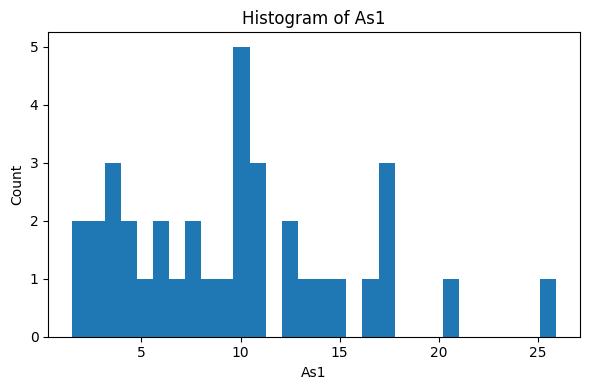

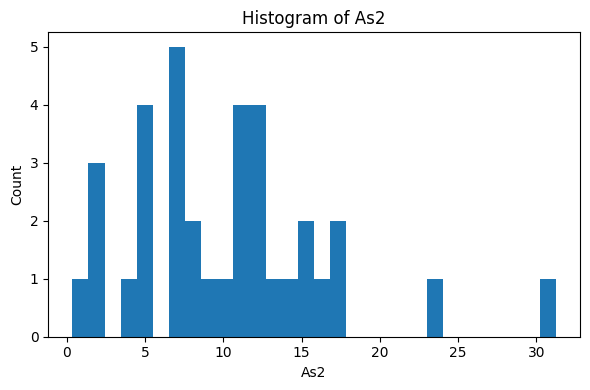

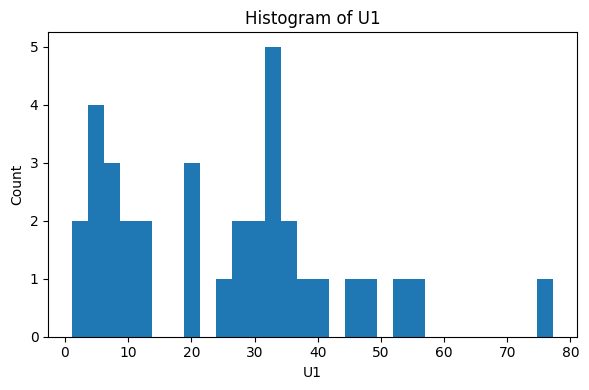

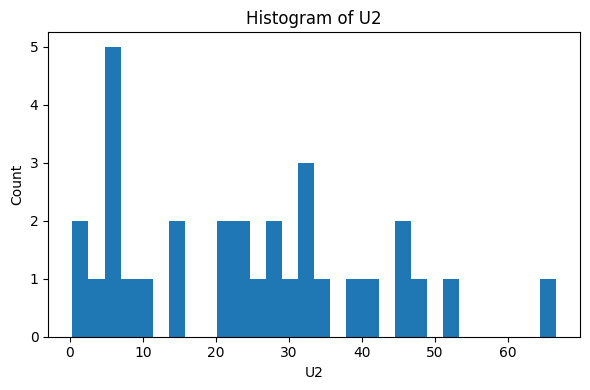

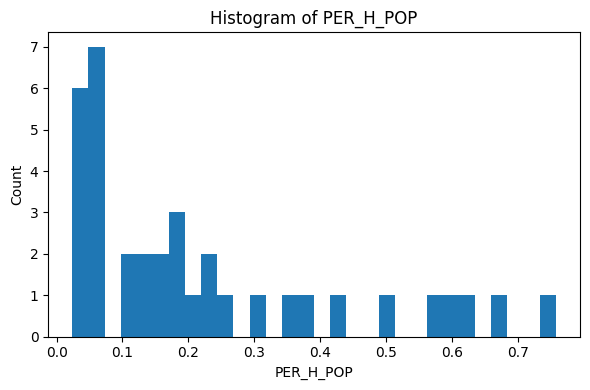

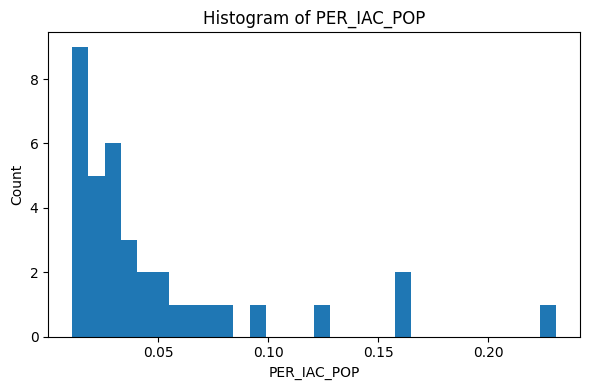

In [7]:
print("\n~Histogams~")

for v in variables:
    vals = [row[v] for row in merged if row[v] is not None]
    if len(vals) == 0:
        continue
    plt.figure(figsize=(6,4))
    plt.hist(vals, bins=30)
    plt.title(f"Histogram of {v}")
    plt.xlabel(v)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

In [60]:
def paired(v1, v2):
    xs, ys, names = [], [], []
    for row in merged:
        a, b = row[v1], row[v2]
        if a is not None and b is not None:
            xs.append(a)
            ys.append(b)
            names.append(row["Full.Name"])
    return xs, ys, names

print("\n~CORRELATIONS (ALL COUNTIES)~")

for tox in ["As1", "As2", "U1", "U2"]:
    for demo_v in ["PER_H_POP", "PER_IAC_POP"]:
        xs, ys, used = paired(tox, demo_v)

        if len(xs) < 3:
            print(f"{tox} vs {demo_v}: insufficient data")
            continue

        p, _ = pearsonr(xs, ys)
        s, _ = spearmanr(xs, ys)

        print(f"\n{tox} vs {demo_v}: n={len(xs)}")
        print("  Pearson:", p)
        print("  Spearman:", s)


~CORRELATIONS (ALL COUNTIES)~

As1 vs PER_H_POP: n=36
  Pearson: 0.018886794303993298
  Spearman: 0.04993564993564994

As1 vs PER_IAC_POP: n=36
  Pearson: 0.2765998938430708
  Spearman: 0.24169884169884173

As2 vs PER_H_POP: n=35
  Pearson: 0.06531156322434858
  Spearman: 0.08333916961399555

As2 vs PER_IAC_POP: n=35
  Pearson: 0.26346540398663204
  Spearman: 0.19329084717195608

U1 vs PER_H_POP: n=35
  Pearson: -0.09338079918100065
  Spearman: -0.07675070028011205

U1 vs PER_IAC_POP: n=35
  Pearson: -0.32033895180099853
  Spearman: -0.48375350140056034

U2 vs PER_H_POP: n=31
  Pearson: 0.01470738267674972
  Spearman: 0.06048387096774194

U2 vs PER_IAC_POP: n=31
  Pearson: -0.15677641428736513
  Spearman: -0.24072580645161293



~LINEAR REGRESSIONS~
As1 ~ PER_H_POP: slope=0.5167945766683437, intercept=9.606523973980924, r=0.01888679430399329


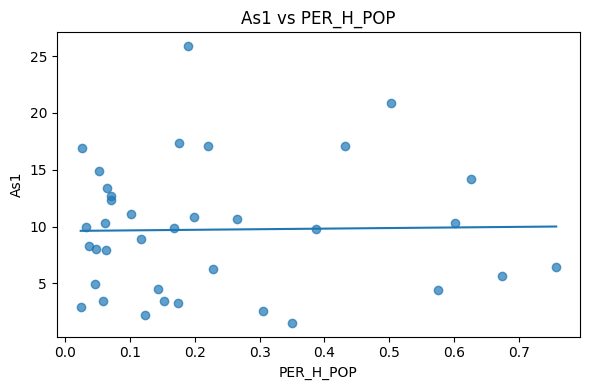

As1 ~ PER_IAC_POP: slope=32.16952535963055, intercept=8.140626383035842, r=0.2765998938430708


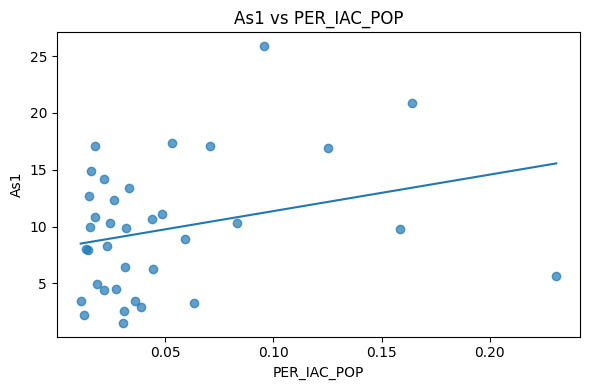

As2 ~ PER_H_POP: slope=1.9512474013777263, intercept=9.78328298821936, r=0.06531156322434856


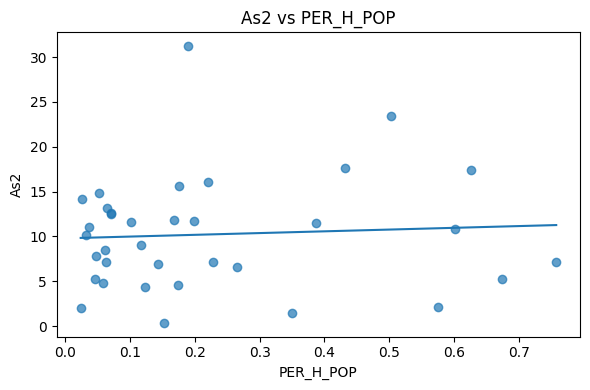

As2 ~ PER_IAC_POP: slope=33.453074806573895, intercept=8.555920135802461, r=0.2634654039866319


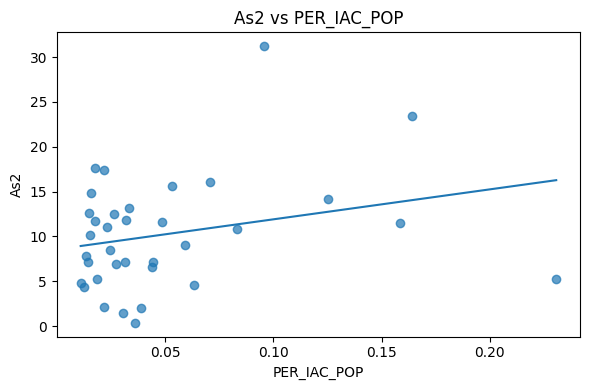

U1 ~ PER_H_POP: slope=-7.956926919893416, intercept=27.134489994179216, r=-0.09338079918100063


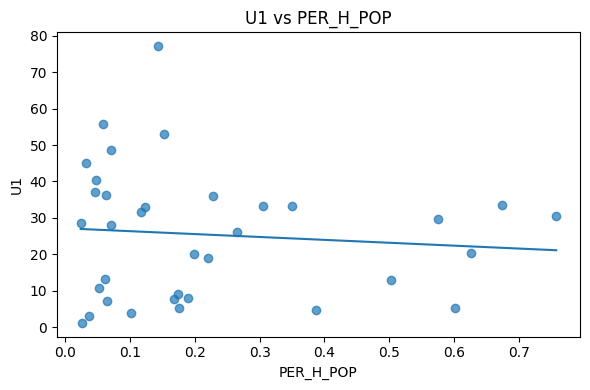

U1 ~ PER_IAC_POP: slope=-115.05829828340305, intercept=31.15082336864827, r=-0.32033895180099864


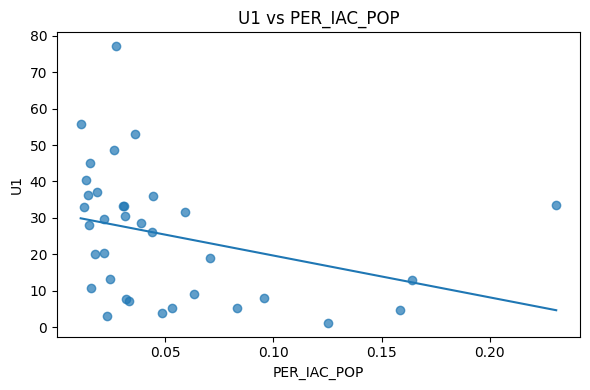

U2 ~ PER_H_POP: slope=1.1696274796914081, intercept=23.88764962849759, r=0.014707382676749675


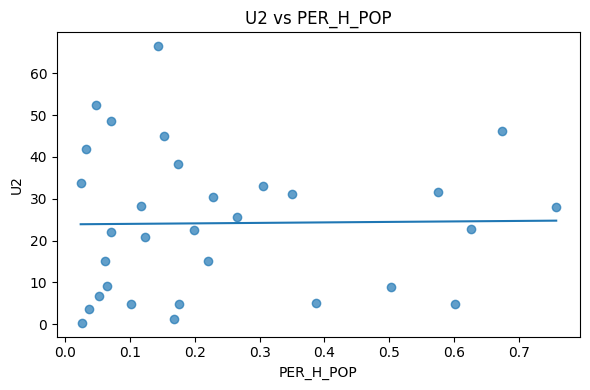

U2 ~ PER_IAC_POP: slope=-52.862624810190816, intercept=26.915695495713017, r=-0.15677641428736516


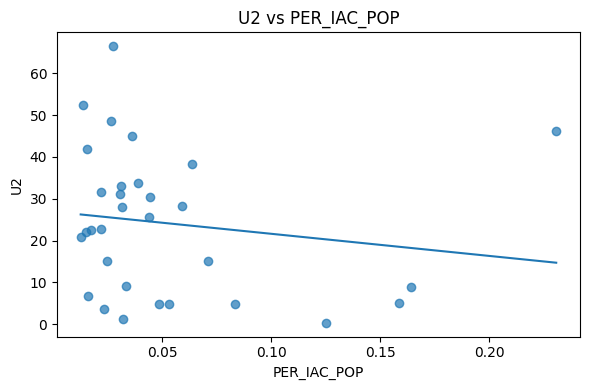

In [61]:
print("\n~LINEAR REGRESSIONS~")

for tox in ["As1", "As2", "U1", "U2"]:
    for demo_v in ["PER_H_POP", "PER_IAC_POP"]:
        xs, ys, _ = paired(demo_v, tox)

        if len(xs) < 3:
            continue

        xs = np.array(xs, dtype=float)
        ys = np.array(ys, dtype=float)

        res = linregress(xs, ys)

        print(f"{tox} ~ {demo_v}: slope={res.slope}, intercept={res.intercept}, r={res.rvalue}")

        plt.figure(figsize=(6,4))
        plt.scatter(xs, ys, alpha=0.7)
        lineX = np.linspace(xs.min(), xs.max(), 200)
        lineY = res.intercept + res.slope * lineX
        plt.plot(lineX, lineY)
        plt.xlabel(demo_v)
        plt.ylabel(tox)
        plt.title(f"{tox} vs {demo_v}")
        plt.tight_layout()
        plt.show()


~PCA~

Explained variance:
PC1: 0.4979355846247814
PC2: 0.22109761868722638
PC3: 0.15653787585862297
PC4: 0.09051018120973738
PC5: 0.023453976775363577
PC6: 0.010464762844268139

PC1 Loadings:
  As1: -0.4988093545678864
  As2: -0.48695802244932107
  U1: 0.48678645985897195
  U2: 0.4443109131502758
  PER_H_POP: -0.09586277104883645
  PER_IAC_POP: -0.2655149642641492


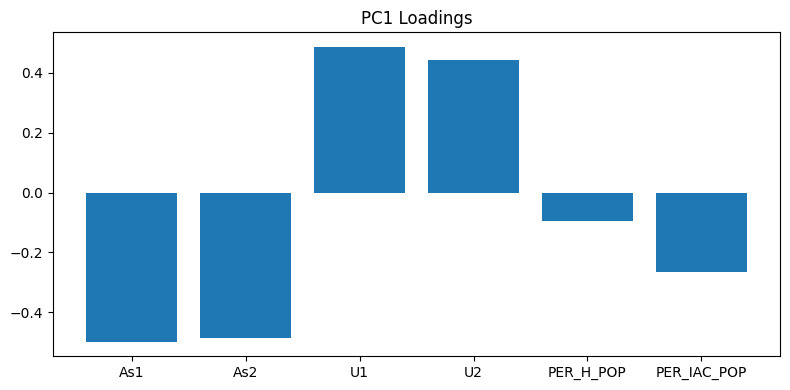

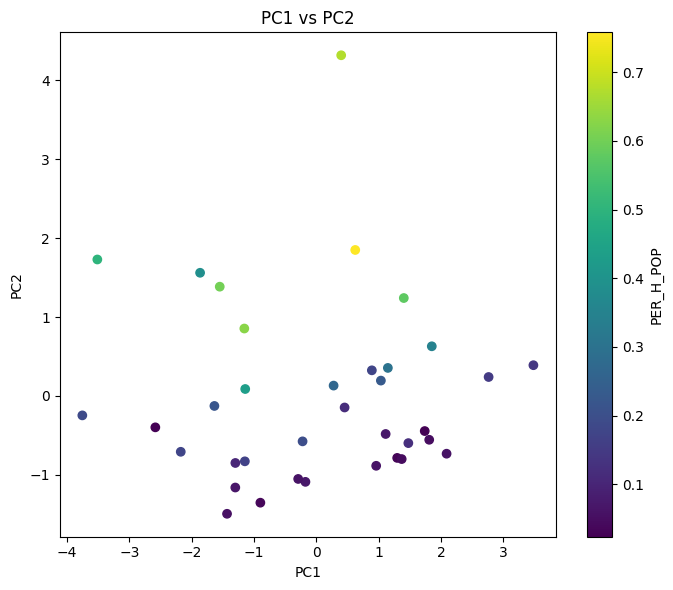

In [64]:
print("\n~PCA~")

pca_vars = ["As1", "As2", "U1", "U2", "PER_H_POP", "PER_IAC_POP"]

X = []
for row in merged:
    X.append([row[v] if row[v] is not None else np.nan for v in pca_vars])
X = np.array(X, dtype=float)

col_means = np.nanmean(X, axis=0)
idx = np.where(np.isnan(X))
X[idx] = np.take(col_means, idx[1])

means = X.mean(axis=0)
stds = X.std(axis=0, ddof=1)
stds[stds == 0] = 1
Xs = (X - means) / stds
U, S, Vt = np.linalg.svd(Xs, full_matrices=False)
pcs = U * S
explained = (S**2) / np.sum(S**2)

print("\nExplained variance:")
for i,e in enumerate(explained):
    print(f"PC{i+1}: {e}")

loadings = Vt.T

print("\nPC1 Loadings:")
for name, weight in zip(pca_vars, loadings[:,0]):
    print(f"  {name}: {weight}")

plt.figure(figsize=(8,4))
plt.bar(pca_vars, loadings[:,0])
plt.title("PC1 Loadings")
plt.tight_layout()
plt.show()


plt.figure(figsize=(7,6))
plt.scatter(pcs[:,0], pcs[:,1], c=[row["PER_H_POP"] if row["PER_H_POP"] is not None else 0 for row in merged], cmap="viridis")
plt.colorbar(label="PER_H_POP")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PC1 vs PC2")
plt.tight_layout()
plt.show()